In [87]:
### Application: Train a model to classify Iris flowers by species
#  1. Build a model
#  2. Train this model
#  3. Use the model to make predictions about unknown data.

# We're going to classify Iris flowers based on the length and width measurements of their sepals and petals.
# A more complex approach would be to take picture of Itris flowers as input (CNN)
# The Iris flowers contain more that 300 species, but we will only consider the 3 following ones: 
# Iris setosa
# Iris virginica
# Iris versicolor


In [88]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import helper libraries
import os
import matplotlib.pyplot as plt

import tensorflow as tf

# About eager excecution: 

# it is an imperative programming environment that evaluates operations immediately,
# without building graphs: operations return concrete values instead of constructing a computational graph
# to run later.
tf.enable_eager_execution()

# Check TF version and eager execution
print('TF version: ', tf.__version__)
print('Enable eager execution: ', tf.executing_eagerly())

TF version:  1.15.0-dev20190821
Enable eager execution:  True


In [89]:
# 1/ Import and parse the data sets.

# Import the dataset of 120 Iris flowers with sepal and pepal measurements

dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv'
# Downloads a file from a URL
dataset_file = tf.keras.utils.get_file(fname = os.path.basename(dataset_url), # Name of the file
                                       origin = dataset_url) # URL

print('Local copy of the dataset: ', dataset_file)


Local copy of the dataset:  /Users/nicolas/.keras/datasets/iris_training.csv


In [90]:
# Let's explore the first entries of the dataset(csv file)
!head -n5 {dataset_file}

# From the header: 120 examples, each of them have 4 features as well as 3 possible labels
# From the rows: The first 4 fields are features, the last field is the label value (value we want to predict)

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [91]:
# Let's define create data structures to store the dataset in a more eligible way

column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

features_names = column_names[:-1]
label_name = column_names[-1]

print('Features: ', features_names)
print('Label/Output: ', label_name)
print('Species/Class names: ', class_names)

# Each label is associated with a string name:
# 0: Iris setosa
# 1: Iris versicolor
# 2: Iris virginica

Features:  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label/Output:  species
Species/Class names:  ['Iris setosa', 'Iris versicolor', 'Iris virginica']


In [92]:
# In TF there exist many method for loading a dataset into a model.
# Let's transform the CSV file into a tf Database

batch_size = 32

dataset = tf.contrib.data.make_csv_dataset(dataset_file,
                                           batch_size,
                                           column_names = column_names,
                                           label_name = label_name,
                                           num_epochs = 1) # specifying the number of times this dataset is repeated

# A dataset, where each element is a (features, labels) tuple that corresponds to a batch of batch_size CSV rows.
# The features dictionary maps feature column names to Tensors containing the corresponding column data,
# and labels is a Tensor containing the column data for the label column specified by label_name.

In [93]:
# Let's explore the dataset
# the dataset are iterable

# The 1st element contains the training examples in the 1st mini-batch
features, labels = next(iter(dataset))

print('Features of the first batch: ', features)
print('-'*30)
print('Labels: ', labels)

Features of the first batch:  OrderedDict([('sepal_length', <tf.Tensor: id=95276, shape=(32,), dtype=float32, numpy=
array([5.7, 7.7, 5.8, 6.5, 5.9, 7.3, 4.9, 4.4, 4.6, 5.1, 6.8, 5. , 4.6,
       7.2, 4.9, 4.4, 6.3, 7. , 6. , 6.7, 5.3, 6.3, 6.2, 6.4, 5.6, 6. ,
       5.4, 5.6, 5.5, 7.2, 5.1, 6.4], dtype=float32)>), ('sepal_width', <tf.Tensor: id=95277, shape=(32,), dtype=float32, numpy=
array([3.8, 2.8, 2.6, 3. , 3. , 2.9, 3. , 2.9, 3.1, 3.5, 2.8, 3.5, 3.6,
       3.6, 3.1, 3. , 2.3, 3.2, 2.7, 3. , 3.7, 2.7, 3.4, 2.8, 2.7, 3. ,
       3.7, 2.9, 3.5, 3. , 3.8, 3.2], dtype=float32)>), ('petal_length', <tf.Tensor: id=95274, shape=(32,), dtype=float32, numpy=
array([1.7, 6.7, 4. , 5.2, 5.1, 6.3, 1.4, 1.4, 1.5, 1.4, 4.8, 1.6, 1. ,
       6.1, 1.5, 1.3, 4.4, 4.7, 5.1, 5.2, 1.5, 4.9, 5.4, 5.6, 4.2, 4.8,
       1.5, 3.6, 1.3, 5.8, 1.9, 4.5], dtype=float32)>), ('petal_width', <tf.Tensor: id=95275, shape=(32,), dtype=float32, numpy=
array([0.3, 2. , 1.2, 2. , 1.8, 1.8, 0.2, 0.2, 0.2, 0.3, 1.4, 0

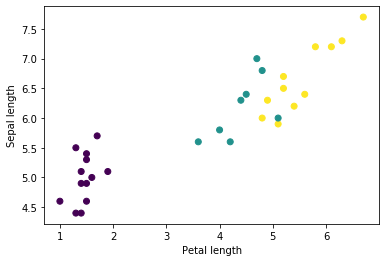

In [94]:
# Let's plot two features against each other: 'petal_length' and 'sepal_length'

# Mini-batch 1
plt.scatter(features['petal_length'].numpy(), features['sepal_length'].numpy(),
            c = labels.numpy(), # pass colors as integers
            cmap = 'viridis') # color map

plt.xlabel('Petal length')
plt.ylabel('Sepal length')
plt.show()

# We can already observe some clusters/pattern according to the flower class

In [95]:
# To simplify the model building step, let's create a method to stack the features of each training example together
# So that the input is as shape (batch size x nb features)

def stack_features(features, labels):
    ''' Transform a dictionary of features into a single list of features.
    
        features          dictionary of features 
        labels            labels of the current mini batch (list of integers)
    '''
    features = tf.stack(list(features.values()), axis = 1)
    return features, labels
                        
# Transform the datasets         
dataset = dataset.map(stack_features) # Apply stack_features to each element of this dataset (mini-batch)
    

In [96]:
# Let's look at the first entries in database

features, labels = next(iter((dataset)))

print('Shape input: ', features.shape)
print('First 10 examples in the training set: ', features[:10]) # (10 x 4)
print('-'*30)
print('First 10 classes in the training set: ', labels[:10]) # (10 x 1)

Shape input:  (32, 4)
First 10 examples in the training set:  tf.Tensor(
[[5.7 3.8 1.7 0.3]
 [7.7 2.8 6.7 2. ]
 [5.8 2.6 4.  1.2]
 [6.5 3.  5.2 2. ]
 [5.9 3.  5.1 1.8]
 [7.3 2.9 6.3 1.8]
 [4.9 3.  1.4 0.2]
 [4.4 2.9 1.4 0.2]
 [4.6 3.1 1.5 0.2]
 [5.1 3.5 1.4 0.3]], shape=(10, 4), dtype=float32)
------------------------------
First 10 classes in the training set:  tf.Tensor([0 2 1 2 2 2 0 0 0 0], shape=(10,), dtype=int32)


In [97]:
### 2/ Select the type of model for the problem
# We'll use a NN with 2 hidden layer

# The TensorFlow tf.keras API is the preferred way to create models and layers.
# The tf.keras.Sequential model is a linear stack of layers. Its constructor takes a list of layer instances

# FC(10) -> ReLU -> FC(10) -> ReLU -> FC(3)
model_NN = tf.keras.Sequential([tf.keras.layers.Dense(10, activation = tf.nn.relu, input_shape = (4,)), # The layer will take as input arrays of shape (*, 4) and output arrays of shape (*, 10)
                                tf.keras.layers.Dense(10, activation = tf.nn.relu),
                                tf.keras.layers.Dense(3)])

# Let's check the prediction of the untrained model on the first training example
predictions = model_NN(features[:10])
print('Predictions on the first 10 training examples: ', predictions)

Predictions on the first 10 training examples:  tf.Tensor(
[[-6.0649395  -0.6254371   4.2381067 ]
 [-7.2500014  -0.8103765   3.1136494 ]
 [-5.6045785  -0.6290287   3.0504935 ]
 [-6.212448   -0.5489376   2.9030764 ]
 [-5.51375    -0.3151517   2.4465847 ]
 [-6.8439665  -0.68653184  3.0212684 ]
 [-5.267942   -0.6531754   3.6416938 ]
 [-4.64526    -0.47404915  3.2368684 ]
 [-4.8305497  -0.46050772  3.3794801 ]
 [-5.467677   -0.5505314   3.848291  ]], shape=(10, 3), dtype=float32)


In [98]:
# Let's use softmax activation function to convert the output to probabilities
predictions = tf.nn.softmax(model_NN(features[:10]))
print('Predictions on the first 10 training examples: ', predictions)

# Let's take the argmax of each prediction to get the corresponding class index
print('-'*30)
print('Predicted class on the first 10 training examples: ', tf.argmax(predictions, axis=1))
print('Actual class of the first 10 training examples: ', labels[:10])

Predictions on the first 10 training examples:  tf.Tensor(
[[3.32727141e-05 7.66362157e-03 9.92303133e-01]
 [3.09464922e-05 1.93778295e-02 9.80591238e-01]
 [1.69923194e-04 2.46097185e-02 9.75220382e-01]
 [1.06558000e-04 3.07055824e-02 9.69187856e-01]
 [3.28186230e-04 5.94077297e-02 9.40264046e-01]
 [5.07032564e-05 2.39428356e-02 9.76006508e-01]
 [1.33245820e-04 1.34530580e-02 9.86413717e-01]
 [3.68283567e-04 2.38625109e-02 9.75769222e-01]
 [2.66120333e-04 2.10359991e-02 9.78697836e-01]
 [8.88755676e-05 1.21414745e-02 9.87769663e-01]], shape=(10, 3), dtype=float32)
------------------------------
Predicted class on the first 10 training examples:  tf.Tensor([2 2 2 2 2 2 2 2 2 2], shape=(10,), dtype=int64)
Actual class of the first 10 training examples:  tf.Tensor([0 2 1 2 2 2 0 0 0 0], shape=(10,), dtype=int32)


In [99]:
### 3/ Train the model
# Define the loss function

def loss(model, X, Y):
    ''' Compute the loss function of the model according to the cross-entropy formula
    '''
    predictions = model(X)
    loss = tf.losses.sparse_softmax_cross_entropy(labels = Y, logits = predictions) # -sum(Y*log(predictions) )
    return loss

# Compute the loss of the untrained model
l = loss(model_NN, features, labels)
print('Cost function of the untrained model: ', l.numpy())

Cost function of the untrained model:  4.64447


In [100]:
# Compute the derivative of the cost function with GradientTape

def compute_gradient(model, X, Y):
    ''' Compute and return the derivative of the cost function for each parameters in the model
    '''
    with tf.GradientTape() as t:
        cost_value = loss(model, X, Y)
    return cost_value, t.gradient(cost_value, model.trainable_variables)

cost, gradient = compute_gradient(model_NN, features, labels)
print('Cost function of the untrained model: ', cost.numpy())
print('Gradient of the untrained model: ', gradient) # List of Tensor. One tensor per parameter type in each layer

Cost function of the untrained model:  4.64447
Gradient of the untrained model:  [<tf.Tensor: id=95536, shape=(4, 10), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  2.2423170e+00,  1.7622962e+00,
         1.3015466e+00,  2.4711764e+00,  7.1712542e-01, -3.0758295e+00,
         3.6150450e-03, -5.9100487e-03],
       [ 0.0000000e+00,  0.0000000e+00,  1.3351442e+00,  1.1192100e+00,
         8.1600636e-01,  1.4621854e+00,  5.0482416e-01, -1.7958728e+00,
         1.4933650e-03, -3.9958935e-03],
       [ 0.0000000e+00,  0.0000000e+00,  9.9815434e-01,  6.5582788e-01,
         5.1746392e-01,  1.1178914e+00,  1.8325503e-01, -1.4674596e+00,
         3.1573479e-03, -1.6860926e-03],
       [ 0.0000000e+00,  0.0000000e+00,  2.4943194e-01,  1.4563921e-01,
         1.2155946e-01,  2.8428742e-01,  2.5854066e-02, -3.8364422e-01,
         1.1423369e-03, -2.8971618e-04]], dtype=float32)>, <tf.Tensor: id=95535, shape=(10,), dtype=float32, numpy=
array([ 0.0000000e+00,  0.0000000e+00,  4.16

In [101]:
# Create an optimizer

# Let's use Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)

# Count the number of time the parameters are updated (epochs * number of mini-batches)
global_step_counter = tf.Variable(0)

In [102]:
# Train the model for two mini-batches

cost_value, gradient = compute_gradient(model_NN, features, labels)
print('Iteration: ', global_step_counter.numpy(), ' // Initial loss: ', cost_value.numpy())

optimizer.apply_gradients(zip(gradient, model_NN.trainable_variables), # list of (gradient, variable) pairs
                          global_step_counter) # will increment step by one
print('Iteration: ', global_step_counter.numpy(), ' // Loss: ', loss(model_NN, features, labels).numpy())

Iteration:  0  // Initial loss:  4.64447
Iteration:  1  // Loss:  3.247139


In [103]:
# The model is ready for training

from tensorflow import contrib
tfe = contrib.eager

# Keep track of the training cost function value and accuracy at the end of each epoch
cost_history = []
accuracy_history = []

epochs = 201

for epoch in range(epochs):
    # Define object to compute the mean and accuracy at each epoch
    epoch_average_loss = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()
    
    # Loop over all the mini-batches
    for x, y in dataset:
        # Update the parameters
        cost_mini_batch, gradient_mini_batch = compute_gradient(model_NN, x, y)
        optimizer.apply_gradients(zip(gradient_mini_batch, model_NN.trainable_variables),
                                  global_step_counter)
        
        # Keep track of progress
        epoch_average_loss(cost_mini_batch) # Add current mini batch cost function value
        # Pass the prections and actual label to compute the accuracy on the current mini batch
        epoch_accuracy(tf.argmax(model_NN(x), axis = 1, output_type=tf.int32), y) 
    
    # Compute the cost function/accuracy for the entier batch (for one epoch)
    cost_history.append(epoch_average_loss.result())
    accuracy_history.append(epoch_accuracy.result())
    
    # Print some intermediate results
    
    if epoch % 10 == 0:
        print('Epoch: ', epoch, ' // Cost function: ', cost_history[-1].numpy(), ' // Accuracy: ', accuracy_history[-1].numpy())
        

Epoch:  0  // Cost function:  2.4621672928333282  // Accuracy:  0.19166666666666668
Epoch:  10  // Cost function:  0.7778570801019669  // Accuracy:  0.7
Epoch:  20  // Cost function:  0.5852166563272476  // Accuracy:  0.7083333333333334
Epoch:  30  // Cost function:  0.48268692940473557  // Accuracy:  0.8
Epoch:  40  // Cost function:  0.4228135347366333  // Accuracy:  0.8916666666666667
Epoch:  50  // Cost function:  0.37889987975358963  // Accuracy:  0.8916666666666667
Epoch:  60  // Cost function:  0.34284983575344086  // Accuracy:  0.9333333333333333
Epoch:  70  // Cost function:  0.3118067756295204  // Accuracy:  0.95
Epoch:  80  // Cost function:  0.28469233959913254  // Accuracy:  0.9333333333333333
Epoch:  90  // Cost function:  0.26098940894007683  // Accuracy:  0.9416666666666667
Epoch:  100  // Cost function:  0.24035395681858063  // Accuracy:  0.9416666666666667
Epoch:  110  // Cost function:  0.2224670983850956  // Accuracy:  0.95
Epoch:  120  // Cost function:  0.20703602

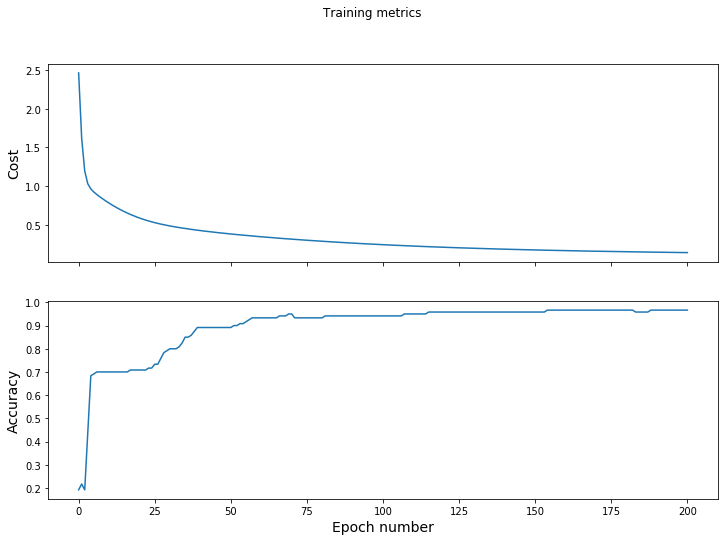

In [106]:
### 4/ Visualization
# Let's visualize the cost function / accuracy over time

# We can use TensorBoard to create nice visualization, but let's use matplotlib

# Create a figure and a set of subplots.
# Args: (Number of columns or rows, True is the figure share the x-axis, size of the figure(top-level container))
fig, axis = plt.subplots(2, sharex=True, figsize=(12, 8)) 
plt.suptitle('Training metrics')

# Set the axis of the first subplot
axis[0].set_ylabel('Cost', fontsize=14)
axis[0].plot(cost_history)

axis[1].set_ylabel('Accuracy', fontsize=14)
axis[1].set_xlabel('Epoch number', fontsize=14)
axis[1].plot(accuracy_history)

plt.show()

In [108]:
# Now let's evaluate our model on a test set

test_set_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"
# Download the test set
test_set_file = tf.keras.utils.get_file(fname = os.path.basename(test_set_url),
                                        origin = test_set_url)

8192/573 [============================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 0us/step


In [109]:
# Construct a dataset from the CSV file

test_dataset = tf.contrib.data.make_csv_dataset(test_set_file,
                                           batch_size,
                                           column_names = column_names,
                                           label_name = 'species',
                                           num_epochs = 1, # specifying the number of times this dataset is repeated
                                           shuffle = False) # No need to shuffle the test set

# Transform the dataset in the suitable shape for the model_NN
test_dataset = test_dataset.map(stack_features)

In [117]:
# Compute the accuracy on the test set

accuracy_test_set = tfe.metrics.Accuracy()

# Iterate over all the mini-batches
for (x, y) in test_dataset:
    predictions = model_NN(x)
    accuracy_test_set(tf.argmax(predictions, axis = 1, output_type=tf.int32), y)
    
print('Accuracy on the test set: ', accuracy_test_set.result().numpy())
print('-' * 30)
# Let's look at the prediction on the last mini-batch
print('Prediction on the last mini-batch: ', tf.argmax(predictions, axis = 1).numpy())
print('Actual class on the last mini-batch: ', y.numpy())
print('Any difference ?', (tf.argmax(predictions, axis = 1).numpy() != y.numpy()).astype(int))

Accuracy on the test set:  0.9666666666666667
------------------------------
Prediction on the last mini-batch:  [1 2 0 1 1 1 0 2 1 2 2 0 2 1 1 0 1 0 0 2 0 1 2 2 1 1 0 1 2 1]
Actual class on the last mini-batch:  [1 2 0 1 1 1 0 2 1 2 2 0 2 1 1 0 1 0 0 2 0 1 2 1 1 1 0 1 2 1]
Any difference ? [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [126]:
# Let's make prediction on unlabeled data 

# Generate some input
unlabeled_data = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]])

# Compute the predictions
predictions = model_NN(unlabeled_data)

for i, prediction in enumerate(predictions):
    # Get the probabilities for the 3 classes
    p = tf.nn.softmax(prediction)
    # Pick the highest one
    class_index = tf.argmax(p).numpy()
    # Get the class name
    name = class_names[class_index]
    print('Example ', i, ', predicted class: ', name, ' (',tf.reduce_max(p).numpy(),').')

Example  0 , predicted class:  Iris setosa  ( 0.97964966 ).
Example  1 , predicted class:  Iris versicolor  ( 0.9279401 ).
Example  2 , predicted class:  Iris virginica  ( 0.6989055 ).
